In [1]:

import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt
import numpy as np
import jax.numpy as jnp
import jax

import equinox as eqx  # https://github.com/patrick-kidger/equinox
import matplotlib.pyplot as plt
import optax
import pandas as pd
import logging

logging.basicConfig(filename='errors.log', level=logging.ERROR)
jax.config.update("jax_enable_x64", True)

[{'p_qsmax': -0.1547625959528065, 'p_Ks': 0.023775849754291825, 'p_a': -1.40669506045701, 'p_ms': -0.19469329161409285}, {'p_qsmax': -0.47597850181516793, 'p_Ks': 0.007747246838751909, 'p_a': -1.7993712726470095, 'p_ms': -0.03324463446137696}, {'p_qsmax': -0.342213142468114, 'p_Ks': 0.00517601916435646, 'p_a': -1.7761647699174785, 'p_ms': -0.05053198275101878}, {'p_qsmax': -0.4295288483950921, 'p_Ks': 0.09799252258518087, 'p_a': -1.6582878220970336, 'p_ms': -0.04235035162223133}, {'p_qsmax': -0.21717978262861637, 'p_Ks': 0.05154037088700001, 'p_a': -1.4939140876664792, 'p_ms': -0.07125158884967359}, {'p_qsmax': -0.1976128600256573, 'p_Ks': 0.04918944129262453, 'p_a': -1.6993950749294902, 'p_ms': -0.06023219466856339}, {'p_qsmax': -0.2962773730550806, 'p_Ks': 0.06450993049626282, 'p_a': -1.5440299776946675, 'p_ms': -0.18610221093771215}, {'p_qsmax': -0.2391477997392622, 'p_Ks': 0.06024905925042347, 'p_a': -1.7046927590112242, 'p_ms': -0.12232689387892988}, {'p_qsmax': -0.497766462512143

/tmp/ipykernel_54525/3821743987.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  random_init[name]=float(np.random.uniform(bounds[name]['lb'],bounds[name]['ub'],size=1))


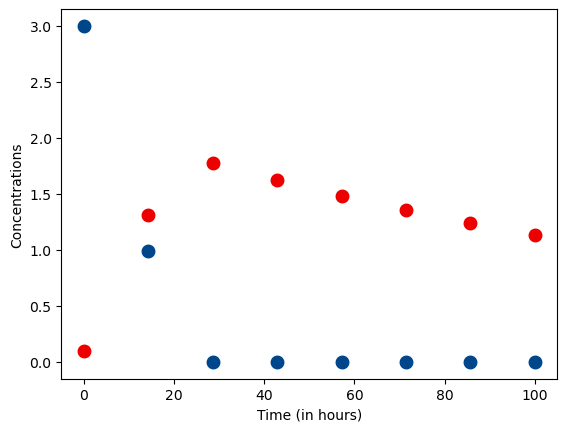

In [2]:
params={"p_qsmax":-0.3,"p_Ks":0.01,"p_a":-1.6,"p_ms":-0.01}




class Bioprocess_4p():
    def __init__(self):
        super().__init__()
    
    def __call__(self,t,y,args):
        params=args[0]
        
        qs=params['p_qsmax']*(y[0]/(params['p_Ks']+y[0]))
        qx=(qs-params['p_ms'])/params['p_a']

        Rs=qs*y[1]
        Rx=qx*y[1]
        dY=jnp.stack([Rs,Rx])
        return dY

class NeuralODE():
    func : Bioprocess_4p()

    def __init__(self):
        super().__init__()

        self.func=Bioprocess_4p()

    def __call__(self,ts,y0,params):
        solution = diffrax.diffeqsolve(
        diffrax.ODETerm(self.func),
        diffrax.Kvaerno3(),
        t0=ts[0],
        t1=ts[-1],
        dt0=ts[1] - ts[0],
        y0=y0,
        args=[params],
        stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-8),
        saveat=diffrax.SaveAt(ts=ts),
        max_steps=10000
        )
        return solution.ys



model_bioprocess=NeuralODE()
model_bioprocess=jax.jit(model_bioprocess)

ts=jnp.linspace(0,100,8)

y_names=["S",'Biomass']
y0=jnp.array([3,0.1])

ys=model_bioprocess(ts=ts,y0=y0,params=params)

plt.scatter(ts,ys[:,0],label=y_names[0],linewidth=4,c="#00468BFF")
plt.scatter(ts,ys[:,1],label=y_names[1],linewidth=4,c="#ED0000FF")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentrations")



def uniform_sampling(bounds,N):
    """Takes a uniform sample between lower and upperbound values"""
    parameter_sets=[]
    names=list(bounds.keys())
    for i in range(N):
        random_init={}
        for name in names:
            random_init[name]=float(np.random.uniform(bounds[name]['lb'],bounds[name]['ub'],size=1))
        parameter_sets.append(random_init)

    return parameter_sets

##initialize prediction dataset
bounds=pd.read_csv("batch_bounds.csv",index_col=0).T


bounds=dict(bounds)
parameter_sets=uniform_sampling(bounds,100)
print(parameter_sets)
# print(params_initial_guess)
# ts_ig=jnp.linspace(0,100,100)
# ys_ig=model_bioprocess(ts=ts_ig,y0=y0,params=params_initial_guess)

# plt.plot(ts_ig,ys_ig[:,0],label="S (initial guess)",linewidth=2,c="#0099B4FF")
# plt.plot(ts_ig,ys_ig[:,1],label="X (initial guess)",linewidth=2,c="#AD002AFF")
# plt.xlabel("Time (in hours)")
# plt.ylabel("Concentrations")
# plt.legend()

In [3]:
# ### simple learning system to test whether grads works as expected
def loss_func(params,ts,ys):
    """A very simple loss function, later we need to add functionality for missing data"""
    yscale=jnp.max(ys,axis=0)-jnp.min(ys,axis=0)
    ys=ys*(1/yscale)

    y_pred=model_bioprocess(ts,y0,params)*(1/yscale)
    return jnp.mean((ys - y_pred) ** 2)


@jax.jit
def update(opt_state,params,ts,ys):
    """Update rule for the gradients for parameters"""
    loss=loss_func(params,ts,ys)
    grads=jax.jit(jax.grad(loss_func,0))(params,ts,ys) #loss w.r.t. parameters
    updates,opt_state=optimizer.update(grads,opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state,params,loss,grads



In [4]:
epochs=100



loss_per_param={}
final_loss=[]

for i in range(len(parameter_sets)):
    print(i)
    params_init=parameter_sets[i]
    lr=1e-4
    optimizer = optax.adabelief(lr)
    opt_state = optimizer.init(params_init)
    loss_per_iter=[]
    for _ in range(epochs):
        try:
            opt_state,params_init,loss,grads=update(opt_state,params_init,ts,ys)
        except Exception as e:
            logging.error(f"Error for {i}: {e}")
        loss_per_iter.append(loss)
    
    final_loss.append(loss)

    loss_per_param[i]=loss_per_iter


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [7]:
df=pd.DataFrame(loss_per_param)
np.argmin(df.iloc[-1,:])

49

In [8]:

params_init=parameter_sets[np.argmin(final_loss)]

lr=1e-4
optimizer = optax.adabelief(lr)
opt_state = optimizer.init(params_init)
epochs=1000


losses=[]
for _ in range(epochs):
    try:
        opt_state,params_init,loss,grads=update(opt_state,params_init,ts,ys)
    except Exception as e:
        logging.error(f"Error for {i}: {e}")
    losses.append(loss)


In [46]:
loss

Array(3.9453954e-07, dtype=float32)

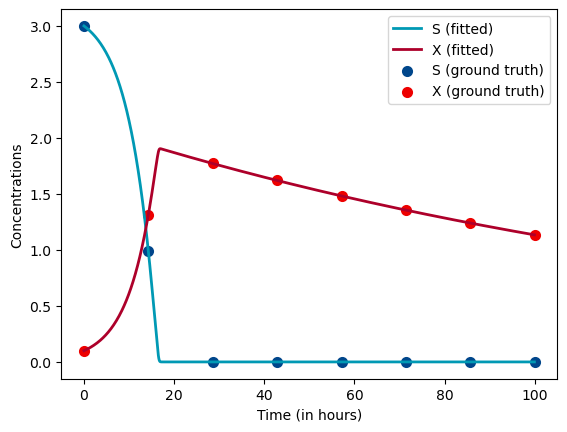

In [10]:
# plt.title("Training")
# plt.plot(losses[0:200])
# plt.xlabel("iterations")
# plt.ylabel("Loss ($(y_{pred}-y_{true})**2$)")

t_pred=jnp.arange(0,100,0.1)
ys_pred=model_bioprocess(t_pred,y0,params=params_init)


ys_true=model_bioprocess(ts,y0,params=params)

plt.plot(t_pred,ys_pred[:,0],label="S (fitted)",linewidth=2,c="#0099B4FF")
plt.plot(t_pred,ys_pred[:,1],label="X (fitted)",linewidth=2,c="#AD002AFF")
plt.scatter(ts,ys_true[:,0],label="S (ground truth)",linewidth=2,c="#00468BFF")
plt.scatter(ts,ys_true[:,1],label="X (ground truth)",linewidth=2,c="#ED0000FF")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentrations")
plt.legend()